# Ridge Regression

#### Author: Yiran Jing

#### Date: Feb 2020


## Contents:
1. Model selection
   - Linear regression
   - Ridge regression
   - Lasso regression
   
Lasso performs best using `Days`, `suspected`, `confirmed_lag1` as regressors

2. Ridge Residual Dignostic

3. Model prediction

## Summary

In [27]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
import datetime
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
# Import models from scikit learn module
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from helper_fun_model import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
## Update data from DXY
! cd ../data_processing && python DXY_AreaData_query.py

2020-02-20 21:35:01Update records successfully to ../data/DXY_Chinese.csv
Save area daily dataset (English) into ../data/DXYArea.csv
CPU times: user 186 ms, sys: 62.8 ms, total: 249 ms
Wall time: 15.7 s


In [28]:
## Load data 
df = pd.read_csv("../data/DXYArea.csv")
"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incompleted)

In [29]:
df = df[df['date']>'2020-01-14']

### Case 1: Overall China

In [30]:
china_df = get_China_total(df)

In [31]:
#features_to_engineer = ['confirmed', 'suspected']
features_to_engineer = ['confirmed'] # only calculate lag 1 for predictor, not regressor.

In [32]:
china_df = feature_engineering(china_df, features_to_engineer)

In [33]:
china_df.tail(2)

,date,country,countryCode,province,city,confirmed,suspected,cured,dead,Days,net_confirmed,confirmed_lag1
8544,2020-02-19,中国,CN,NaN,NaN,74675,4922,16168,2121,73,56386,74276.0
8890,2020-02-20,中国,CN,NaN,NaN,74679,4922,16562,2122,74,55995,74675.0


In [34]:
Train, Test = split_train_test_by_date(china_df, 5) 

regressors = ['Days', 'suspected'] # other variables we want to apply into model
#regressors = ['Days']


X_train = Train.loc[:,regressors + [x+'_lag1' for x in features_to_engineer]]
y_train = Train['confirmed']
X_test =  Test.loc[:,regressors + [x+'_lag1' for x in features_to_engineer]]
y_test = Test['confirmed']

Train dataset: data before 2020-02-15 00:00:00 
Test dataset: the last 5 days


In [35]:
X_train.columns # regressor within model

Index(['Days', 'suspected', 'confirmed_lag1'], dtype='object')

In [36]:
# Use StandardScaler to transform numerical data 
# Note: truning sc based on X_train
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
#X_validate_numerical_sc = sc.transform(X_validate_numerical)
X_test_sc = sc.transform(X_test)

In [37]:
X_train_sc[:3]

array([[-1.67705098, -1.1657803 , -0.86928584],
       [-1.56524758, -1.1657803 , -0.867103  ],
       [-1.45344419, -1.1657803 , -0.86689004]])

## Linear regression

In [38]:
# Fit the linear regression
linear = LinearRegression()
linear.fit(X_train_sc, y_train)

# # Find the validation score
get_validation_score(linear, X_test_sc, y_test)

Linear Regression MAPE on Validation set : 0.06939529458985437
Linear Regression MAE on Validation set : 5063.466757471452
Linear Regression R2 on Validation set : -4.1977356110329564


## LASSO

In [39]:
# Find from default hyperparameters 
lasso = LassoCV(cv=10)
lasso.fit(X_train_sc, y_train)
alpha = lasso.alpha_
print("basic alpha :", alpha)

basic alpha : 101.63028985014307


In [40]:
# Find from more refined list
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 5)
lasso.fit(X_train_sc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 101.63028985014307
Best alpha : 60.97817391008584


In [41]:
# # Find the validation score
get_validation_score(lasso, X_test_sc, y_test)

Linear Regression MAPE on Validation set : 0.060886732860715824
Linear Regression MAE on Validation set : 4443.161894009257
Linear Regression R2 on Validation set : -3.0225991969314325


## Ridge

In [42]:
# Find from default hyperparameters 
ridge = RidgeCV(cv=5)
ridge.fit(X_train_sc, y_train)
alpha = ridge.alpha_
print("basic alpha :", alpha)

basic alpha : 10.0


In [43]:
# Find from more refined list
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], cv = 5)
ridge.fit(X_train_sc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 10.0
Best alpha : 14.0


In [44]:
# # Find the validation score
get_validation_score(ridge, X_test_sc, y_test)

Linear Regression MAPE on Validation set : 0.18347205151634374
Linear Regression MAE on Validation set : 13292.800038148938
Linear Regression R2 on Validation set : -32.84577130780329


### Save prediction result to CSV

In [45]:
train_index = X_train.index
test_index = X_test.index

# Create dataframe
X_train = pd.DataFrame(X_train_sc, columns=X_train.columns, index=train_index)
#X_validate_numerical_sc = pd.DataFrame(X_validate_numerical_sc, columns=numerical, index=validate_index)
X_test = pd.DataFrame(X_test_sc, columns=X_train.columns, index=test_index)

In [46]:
# Calculate the predictions 
predictions_ridge = np.squeeze(ridge.predict(X_test))

# Calculate the residuals
residuals_ridge = np.squeeze(y_test) - predictions_ridge

# Create dataframe
d = {'y_test': np.squeeze(y_test), 'predictions': predictions_ridge, 'residuals_ridge': residuals_ridge}
df_residuals_ridge = pd.DataFrame(data=d, index=test_index)

# Left join the period
df_residuals_ridge['date'] = Test['date']

df_residuals_ridge.shape

# Write to a csv file
df_residuals_ridge.to_csv('prediction/residuals_ridge_test_0216.csv', index_label='test_index')

In [47]:
# Calculate the predictions 
predictions_ridge = np.squeeze(ridge.predict(X_train))

# Calculate the residuals
residuals_ridge = np.squeeze(y_train) - predictions_ridge

# Create dataframe
d = {'y_train': np.squeeze(y_train), 'predictions': predictions_ridge, 'residuals_ridge': residuals_ridge}
df_residuals_ridge = pd.DataFrame(data=d, index=train_index)

# Left join the period
df_residuals_ridge['date'] = Train['date']

# Write to a csv file
df_residuals_ridge.to_csv('prediction/residuals_ridge_train_0216.csv', index_label='train_index')

In [48]:
df_residuals_ridge.head(2)

,y_train,predictions,residuals_ridge,date
135,41,-1953.268874,1994.268874,2020-01-15
138,45,-1202.787100,1247.787100,2020-01-16


## Ridge Residual Dignostic

Since ridge is the optimal model

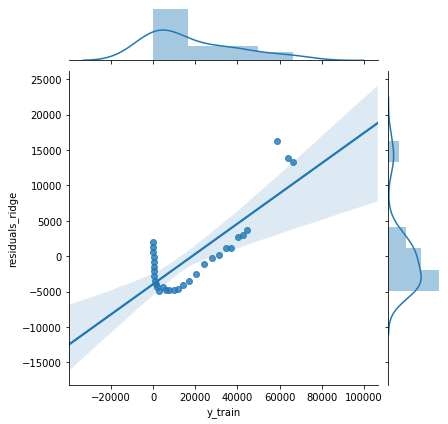

In [49]:
sns.jointplot("y_train", "residuals_ridge", data=df_residuals_ridge, kind="reg")

### Ridge model prediction

In [50]:
ridge_res_train = pd.read_csv('prediction/residuals_ridge_train_0216.csv')
del ridge_res_train['train_index']
ridge_res_test = pd.read_csv('prediction/residuals_ridge_test_0216.csv')
del ridge_res_test['test_index']

ridge_res_test.Timestamp = pd.to_datetime(ridge_res_test.date,format='%Y-%m-%d %H:%M') 
ridge_res_test.index = ridge_res_test.Timestamp
ridge_res_test = ridge_res_test.sort_index()

ridge_res_train.Timestamp = pd.to_datetime(ridge_res_train.date,format='%Y-%m-%d %H:%M') 
ridge_res_train.index = ridge_res_train.Timestamp
ridge_res_train = ridge_res_train.sort_index()

ridge_all = pd.concat([ridge_res_train,ridge_res_test])

In [56]:
## MAPE of test case (14 Feb - 20 Feb)
y = ridge_res_test['y_test'][:7]
y_pred = ridge_res_test['predictions'][:7]
mape = np.abs((y-y_pred))/np.abs(y)
print(np.mean(mape))

0.18347205151634374


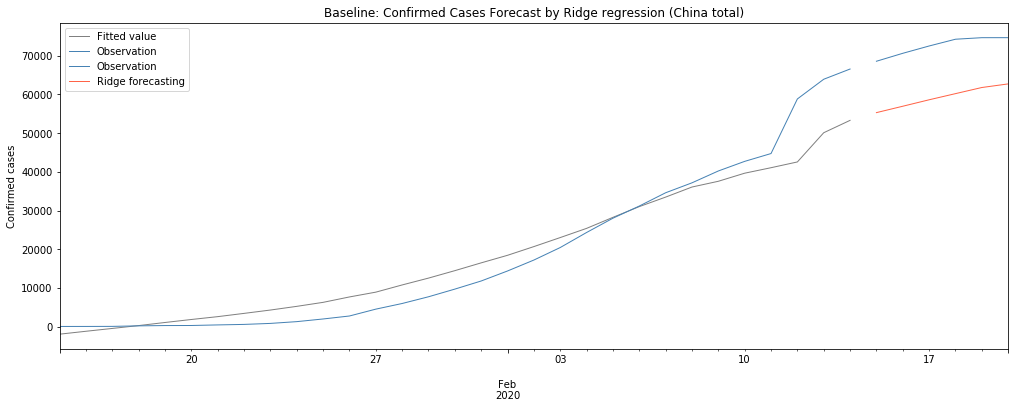

In [51]:
#Plotting data
ridge_res_train['predictions'].plot(figsize=(17,6), title= 'Baseline: Confirmed Cases Forecast by Ridge regression (China total)', fontsize=10,
                                        label= 'Fitted value',linewidth=1, color = 'grey')
ridge_res_train['y_train'].plot(figsize=(17,6),label= 'Observation',linewidth=1, color = 'steelblue')
ridge_res_test['y_test'].plot(figsize=(17,6), label= 'Observation', linewidth=1, color = 'steelblue')

ridge_res_test['predictions'].plot(figsize=(17,6), label= 'Ridge forecasting', color = 'tomato',linewidth=1)
plt.ylabel('Confirmed cases')
plt.xlabel('')
plt.legend()
plt.show()